# Predicting Credit Card Applications

Commercial banks have the task of deciding whether or not credit card applications are successful or not. The teams in charge have to make a judgement call based on the profile of the applicant. Applicants may be rejected for a variety of reasons; high loan balances, low income level and poor credit history are some of the typical reasons application are unsuccessful. Traditionally, these applications are reviewed manually, in a case-by-case fashion. Here, we will train a machine learning classifier to predict the outcome of applications - eliminating the time-consuming process of manual reviews. 

![](https://github.com/Qalif-R/Predicting_Credit_Card_Applications/blob/main/cc_img.png?raw=true)

The data used to train and test our classifiers is the Credit Card Approval dataset from the UCI Machine Learning Repository. Below are the sub tasks to perform in order to successfully build and assess the model:

 **1. Exploratory Analysis**\
 **2. Feature selection**\
 **3. Split the data into train and test sets**\
 **4. Preprocessing the data**\
 **5. Train a few classic models**\
 **6. Cross Fold Validation**\
 **7. Hyper Parameter Tuning to improve model performance**\
 **8. Impementing Ensemble methods to improve model performance**\
 **9. Testing the chosen model on unseen data**\
 
We'll need to peform exploratory data analysis (EDA) to figure out anomilies of the data, and to determine how we can clean and preprocess the data. Steps 4-6 will be tied together using a machine learning pipeline. We then implement several measures to improve the model's performance and finally we assess the chosen model on fresh data.

## 1. Exploratory Data Analysis

In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/Qalif-R/Predicting_Credit_Card_Applications/main/cc_approvals.csv'
cc_apps = pd.read_csv(url)
cc_apps.head()

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


Inspecting the head of the applicant data, values for several of the categorical features are not easily interpretable. Unfortunately, the definition for such values are not disclosed due to privacy reasons. This will of course, not impact our model's ability to make approval predictions. It is clear that the target variable is *Approved*, while the rest of the columns represent the features.

Let's proceed by examining the structure of the data:

In [2]:
#Info of application data
cc_apps_info = cc_apps.info()
cc_apps_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


We notice the Age feature is stored as an object. Since Age is decribed as a decimal number here, we'll change it to a float type feature, and then look at the distribution statistics for all numerical features.

In [3]:
#Change Age from object to float
cc_apps['Age'] = pd.to_numeric(cc_apps['Age'], errors='coerce')

#Summary statistics for numerical features
cc_apps_description = cc_apps.describe()
cc_apps_description

,Age,Debt,YearsEmployed,CreditScore,Income
count,678.000000,690.000000,690.000000,690.00000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,1017.385507
std,11.957862,4.978163,3.346513,4.86294,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,5.000000
75%,38.230000,7.207500,2.625000,3.00000,395.500000
max,80.250000,28.000000,28.500000,67.00000,100000.000000


In [4]:
#Take a random sample of the data
cc_apps.sample(10, random_state=1)

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
666,a,21.75,11.75,u,g,c,v,0.250,f,f,0,t,g,00180,0,-
520,?,20.42,7.50,u,g,k,v,1.500,t,t,1,f,g,00160,234,+
681,b,27.83,1.00,y,p,d,h,3.000,f,f,0,f,g,00176,537,-
23,a,27.42,14.50,u,g,x,h,3.085,t,t,1,f,g,00120,11,+
65,b,34.17,1.54,u,g,cc,v,1.540,t,t,1,t,g,00520,50000,+
339,b,28.00,3.00,u,g,w,v,0.750,f,f,0,t,g,00300,67,-
56,b,23.17,0.00,u,g,cc,v,0.085,t,f,0,f,g,00000,0,+
394,b,41.17,1.25,y,p,w,v,0.250,f,f,0,f,g,00000,195,-
47,b,31.92,4.46,u,g,cc,h,6.040,t,t,3,f,g,00311,300,+
358,b,32.42,3.00,u,g,d,v,0.165,f,f,0,t,g,00120,0,-


Even though the .info() method reported no null values in all columns earlier,the random sample of the data generated above shows the null values are masked by '?' (index 520). Upon further inspection, there were no other symbols which denote null entries. We will replace these with numpy NaN.

In [5]:
import numpy as np
# Replace the '?s with NaN
cc_apps = cc_apps.replace('?', np.nan)

# Count the number of NaNs in the datasets and print the counts to verify
cc_apps_info = cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            678 non-null    object 
 1   Age             678 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         684 non-null    object 
 4   BankCustomer    684 non-null    object 
 5   EducationLevel  681 non-null    object 
 6   Ethnicity       681 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         677 non-null    object 
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    object 
dtypes: float64(3), int64(2), object(11)
memory usage: 86.4+ KB


We are now able to see the actual number of non-null values in each of the columns. 

Now we shall check the proportions of each class in the target variable. This is important as a models trained with high class imbalance will produce misleading results. 

In [6]:
#Check for class imbalance
cc_apps['Approved'].value_counts(normalize=True)

-    0.555072
+    0.444928
Name: Approved, dtype: float64

The target variable split of ~55%-45% may be considered to be balanced, so we can proceed without applying any resampling techniques. This also means that **accuracy** will be a suitable metric for assessing model performance

## 2. Feature Selection

Ideally, we want to get rid of any features which add little to no value in making predictions. For numerical features, if two features are strongly correlated to one another, we can remove 1 of those features.

Let's draw up a correlation matrix to see if such features exist.

In [7]:
# Create a correlation matrix
corr_metrics = cc_apps.corr()
corr_metrics.style.background_gradient()

,Age,Debt,YearsEmployed,CreditScore,Income
Age,1.000000,0.202317,0.395751,0.185912,0.018553
Debt,0.202317,1.000000,0.298902,0.271207,0.123121
YearsEmployed,0.395751,0.298902,1.000000,0.322330,0.051345
CreditScore,0.185912,0.271207,0.322330,1.000000,0.063692
Income,0.018553,0.123121,0.051345,0.063692,1.000000


Since none of the numeric features are strongly correlated, we shall keep all numeric features. 

On the other hand, for the categorical features, it seems unreasonable for applicants to be rejected based on their zip code and whether or not they have a driver's license.
Let's see the proportions of approved and rejected applicants based on *DriversLicense*

In [8]:
cc_apps.groupby('DriversLicense')['Approved'].value_counts(normalize=True)

DriversLicense  Approved
f               -           0.569519
                +           0.430481
t               -           0.537975
                +           0.462025
Name: Approved, dtype: float64

The proportions of approved and rejected applications are similar for driver's license holders and non driver's license holders- so we can drop this feature. We will also go ahead and drop the *ZipCode* feature. There is an argument for the *ZipCode* influencing outcome of the application; perhaps applicants living in more affluent parts of the country tend to have a higher approval rate. If this were the case, it would be captured by the *Income* feature.

Let's now look at the distribution of the numerical features.

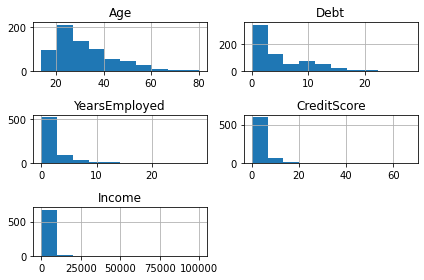

In [9]:
cc_apps.drop(['DriversLicense', 'ZipCode'], axis=1, inplace=True)

import matplotlib.pyplot as plt
cc_apps.hist()
plt.tight_layout()
plt.show()

Since the features do not resemble a normal distribution, a **minmax scaler** is preferred over a standard scaler.

## 3. Splitting the data into train and test sets

We will separate the data into a 80%-20% train-test split. The train set will be used for training and validation by utilising Cross Validation. The test set will only be used in the last step to assess the final model.

In [10]:
from sklearn.model_selection import train_test_split
features = cc_apps.drop(['Approved'], axis=1)
labels = cc_apps['Approved']

train, test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=1, stratify=labels)

## 4-6. Building the Pipeline - Preprocessing, Training, Validation
We will first create pipelines for both numeric and categorical data. For the numerical features, we will replace missing values with the mean of the feature. Numerical features will also be scaled using a minmax scale. The catogorical features will be tranformed using the one hot encoder.

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


#Grouping feature types
numeric_features = ['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']
categorical_features = ['Male', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'Citizen']

#Defining transformer for numeric data
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())]
)

#Defining transformer for categorical data
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

#Combining the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

The transformers have now been defined. We proceed with training some classic classifiers and validate using **5-fold cross validation**. The 3 classic classifiers which we will be comparing here are **Logistic Regression, Decision Tree and K-Nearest Neighbours** (all with their default hyper-parameters)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score

#Defining the 5-fold cv
kf = KFold(n_splits=5, shuffle=True, random_state=1)

#Defining the 3 classifier pipelines
clfs = [LogisticRegression(random_state=1), DecisionTreeClassifier(random_state=1), KNeighborsClassifier()]
pipelines = []

for clf in clfs:
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", clf)]
    )
    pipelines.append(pipeline)

cv_results = []

for pipeline in pipelines:    
    cv_result = cross_val_score(pipeline, # Pipeline
                                train, # Feature matrix
                                labels_train, # Target vector
                                cv=kf, # Cross-validation technique
                                scoring="accuracy", # Loss function
                                n_jobs=-1) # use all cpu cores
    cv_results.append(cv_result)

# Compute mean accuracy of each classifier
means = [np.round(np.mean(cv), 3) for cv in cv_results]
clfs = ['Logistic Regression', 'Decision Tree', 'KNN']
mean_accuracy = dict(zip(clfs,means))

In [13]:
mean_accuracy

{'Logistic Regression': 0.855, 'Decision Tree': 0.817, 'KNN': 0.833}

## 7. Hyper-Parameter Tuning to improve model performance

Among the 3 trained classifiers, Logistic Regression reported the highest accuracy **(~85.5%)**. Now lets see if we can improve the accuracy of the logistic regression model by tuning its hyper-parameters. We will use GridSearchCV to do this. In particular, we will search for the optimal values for 3 hyper-parameters; **tol, C** & **max_iter**.

In simple terms: 
 - large C leads to overfitting, small C leads to underfitting
 - tol (tolerance) controls the minimum difference in parameter values across iterations when determining optimal parameters.
 - max_iter is the maximum number of iterations when determining the optimal parameters
 
Note that the terms hyper-parameters and parameters not equivalent- optimal **parameters** are learnt during training process, whereas **hyper-parameters** cannot be learned by training the model and must be set prior to training the model.

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the grid of values for tol, C and max_iter
tol = [0.01,0.001,0.0001]
C = np.logspace(-5,8,15)
max_iter = [100,150,200]

#Defining the estimator
logreg_pre = Pipeline(
        steps=[("preprocessor", preprocessor), ("logreg", LogisticRegression(random_state=1))]
)

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = {'logreg__tol':tol, 
              'logreg__C':C,
              'logreg__max_iter': max_iter
}

#Instantiate GridSearchCV
grid_model = GridSearchCV(estimator=logreg_pre, 
                          param_grid=param_grid, 
                          cv=kf,
                          scoring='accuracy',
                          n_jobs=-1)

In [15]:
grid_model_result = grid_model.fit(train, labels_train)

In [16]:
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score,best_params))

Best: 0.858755 using {'logreg__C': 0.05179474679231213, 'logreg__max_iter': 100, 'logreg__tol': 0.01}


We observe that the best set of hyper-parameters chosen from the parameter space resulted in a modest increase in accuracy **(85.5% to 85.9%)**. Due to the negligible increase in accuracy, either choice will be fine; so we will proceed with the default hyper-parameters.

## 8. Implementing Ensemble Methods to improve performance
Emsemble methods are techniques which use a group of base model predictors (known as an **emsemble**) and aggregates the outputs of these predictors to produce a final output. We will look at 2 well known ensemble methods; **Bagging** and **AdaBoost**. For classification purposes, each predictor in the ensemble predicts the label of a new instance, and the final prediction is made by weighted majority voting.

### 8.1 Bagging
**Bagging** produces an ensemble of predictors using the same base algorithm, where each is trained on a different subset of the data. These training subsets are obtained through bootstrap sampling (sampling with replacement).

In [17]:
from sklearn.ensemble import BaggingClassifier

#Define base estimator
lr = LogisticRegression(random_state=1)

bag_logreg_pre = Pipeline(
        steps=[("preprocessor", preprocessor), ("bag_logreg", BaggingClassifier(base_estimator=lr, random_state=1))]
)

bag_param_grid = {'bag_logreg__n_estimators':np.arange(1,101)}

#Instantiate GridSearchCV
bag_grid_model = GridSearchCV(estimator=bag_logreg_pre, 
                              param_grid=bag_param_grid, 
                              cv=kf,
                              scoring='accuracy',
                              n_jobs=-1)


bag_grid_model_result = bag_grid_model.fit(train, labels_train)

bag_best_score, bag_best_params = bag_grid_model_result.best_score_, bag_grid_model_result.best_params_
print("Best: %f using %s" % (bag_best_score, bag_best_params))

Best: 0.858755 using {'bag_logreg__n_estimators': 32}


We notice that bagging results in a similar accuracy as the hyper-parameter tuning performed earlier, producing an accuracy score of **85.9%**

### 8.2 AdaBoost
**Boosting** is an emsemble method in which many predictors are trained sequentially using the same base algorithm, and each predictor learns from the errors of its predecessor. **AdaBoost** is a type of boosting where each predictor pays more attention to the instances which were wrongly predicted by its predecessor. AdaBoost does this by changing the weights of of the training instances at each iteration.

In [18]:
from sklearn.ensemble import AdaBoostClassifier

#include ada boost in estimator pipeline
ada_logreg_pre = Pipeline(
        steps=[("preprocessor", preprocessor), ("ada_logreg", AdaBoostClassifier(base_estimator=lr, random_state=1))]
)

ada_param_grid = {'ada_logreg__n_estimators':np.arange(1,101)}

#Instantiate GridSearchCV
ada_grid_model = GridSearchCV(estimator=ada_logreg_pre, 
                              param_grid=ada_param_grid, 
                              cv=kf,
                              scoring='accuracy',
                              n_jobs=-1)

ada_grid_model_result = ada_grid_model.fit(train, labels_train)

ada_best_score, ada_best_params = ada_grid_model_result.best_score_, ada_grid_model_result.best_params_
print("Best: %f using %s" % (ada_best_score, ada_best_params))

Best: 0.864193 using {'ada_logreg__n_estimators': 26}


Implementing AdaBoost increased the accuracy from **85.5% to 86.4%**. Although this is not a significant increase, **we will use this AdaBoosted model as our final classifier** as AdaBoost is well known for generally outperforming base model classifiers.

## 9. Testing on unseen data
Finally we will now see how well our chosen model performs on the test set data, which has not been used at all in the training and validation process. This gives us a general idea on how our model predicts the outcome of new credit card applications.

In [19]:
from sklearn.metrics import accuracy_score

labels_predicted = ada_grid_model.predict(test)
acc_test = accuracy_score(labels_test,labels_predicted)
print(acc_test)

0.8695652173913043


Our AdaBoosted Logistic Regression model managed to achieve an accuracy score of **~87%**, which is slightly higher when compared to the scores obtained during the validation phase. Our credit card application predictor is now ready to be deployed!